# Comparing the performance of optimizers - analysis

In [1]:
import pennylane as qml
import numpy as np
from qiskit import IBMQ
import itertools
import matplotlib.pyplot as plt
import pickle
import scipy

## Hardware-friendly circuit

In [2]:
n_wires = 5

In [3]:
n_shots_list = [10, 100, 1000]
devs = [qml.device("default.qubit", wires=n_wires, shots=shots, analytic=False) for shots in n_shots_list]
devs.append(qml.device("default.qubit", wires=n_wires))

In [4]:
devs

[<DefaultQubit device (wires=5, shots=10) at 0x7fe74d4ab990>,
 <DefaultQubit device (wires=5, shots=100) at 0x7fe6f07af5d0>,
 <DefaultQubit device (wires=5, shots=1000) at 0x7fe6f5cf38d0>,
 <DefaultQubit device (wires=5, shots=1000) at 0x7fe7056a4190>]

In [5]:
def layers_circ(weights):
    for i in range(n_wires):
        qml.RX(weights[i], wires=i)

    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[2, 1])
    qml.CNOT(wires=[3, 1])
    qml.CNOT(wires=[4, 3])
    return qml.expval(qml.PauliZ(1))

In [6]:
layers = [qml.QNode(layers_circ, d) for d in devs]

In [7]:
seed = 2

weights = qml.init.basic_entangler_layers_uniform(n_layers=1, n_wires=5, seed=seed).flatten()
weights

tensor([2.73943676, 0.16289932, 3.4536312 , 2.73521126, 2.6412488 ], requires_grad=True)

In [8]:
grads = [qml.grad(l, argnum=0) for l in layers]

In [9]:
[l(weights) for l in layers]

[-1.0, -0.8, -0.794, -0.7938055593697134]

In [10]:
g_exact = np.round(grads[-1](weights), 7)
g_exact

array([-0.3376347,  0.1304665,  0.2560632, -0.3416029,  0.       ])

## Calculating the Hessian

In [11]:
s = 0.5 * np.pi
denom = 4 * np.sin(s) ** 2
shift = np.eye(len(weights))


def hess_gen_results(func, weights, args=None):
    
    results = {}
    
    if not args:
        args = len(weights)
    
    for c in itertools.combinations(range(args), r=2):
        weights_pp = weights + s * (shift[c[0]] + shift[c[1]])
        weights_pm = weights + s * (shift[c[0]] - shift[c[1]])
        weights_mp = weights - s * (shift[c[0]] - shift[c[1]])
        weights_mm = weights - s * (shift[c[0]] + shift[c[1]])

        f_pp = func(weights_pp)
        f_pm = func(weights_pm)
        f_mp = func(weights_mp)
        f_mm = func(weights_mm)
        results[c] = (f_pp, f_mp, f_pm, f_mm)
    
    f = func(weights)
    
    for i in range(args):
        f_p = func(weights + 0.5 * np.pi * shift[i])
        f_m = func(weights - 0.5 * np.pi * shift[i])
        results[(i, i)] = (f_p, f_m, f)

    return results


def hess_diag_gen_results(func, weights, args=None):
    
    results = {}
    
    if not args:
        args = len(weights)
    
    f = func(weights)
    
    for i in range(args):
        f_p = func(weights + 0.5 * np.pi * shift[i])
        f_m = func(weights - 0.5 * np.pi * shift[i])
        results[(i, i)] = (f_p, f_m, f)

    return results


def grad_gen_results(func, weights, args=None):
    results = {}
    
    if not args:
        args = len(weights)
    
    for i in range(args):
        f_p = func(weights + 0.5 * np.pi * shift[i])
        f_m = func(weights - 0.5 * np.pi * shift[i])
        results[i] = (f_p, f_m)
    
    return results


def get_hess_diag(func, weights, args=None):
    if not args:
        args = len(weights)
        
    hess = np.zeros(args)
    results = hess_diag_gen_results(func, weights, args)
    
    for i in range(args):
        r = results[(i, i)]
        hess[i] = (r[0] + r[1] - 2 * r[2]) / 2
    
    grad = np.zeros(args)
    
    for i in range(args):
        r = results[(i, i)]
        grad[i] = (r[0] - r[1]) / 2
    
    return hess, results, grad


def get_grad(func, weights, args=None):
    
    if not args:
        args = len(weights)
    
    grad = np.zeros(args)
    results = grad_gen_results(func, weights, args)
    
    for i in range(args):
        r = results[i]
        grad[i] = (r[0] - r[1]) / 2
    
    return results, grad
    
    
def get_hess(func, weights, args=None):
    
    if not args:
        args = len(weights)
        
    hess = np.zeros((args, args))
    
    results = hess_gen_results(func, weights, args)
    
    for c in itertools.combinations(range(args), r=2):
        r = results[c]
        hess[c] = (r[0] - r[1] - r[2] + r[3]) / denom
    
    hess = hess + hess.T
    
    for i in range(args):
        r = results[(i, i)]
        hess[i, i] = (r[0] + r[1] - 2 * r[2]) / 2
    
    grad = np.zeros(args)
    
    for i in range(args):
        r = results[(i, i)]
        grad[i] = (r[0] - r[1]) / 2
    
    return hess, results, grad

In [12]:
hess_ps = get_hess(layers[-1], weights)
print(np.around(hess_ps[0], 3))
print(np.around(hess_ps[2], 3))
print(np.allclose(g_exact, hess_ps[2]))

[[ 0.794  0.055  0.109 -0.145  0.   ]
 [ 0.055  0.794 -0.042  0.056 -0.   ]
 [ 0.109 -0.042  0.794  0.11   0.   ]
 [-0.145  0.056  0.11   0.794  0.   ]
 [ 0.    -0.     0.     0.    -0.   ]]
[-0.338  0.13   0.256 -0.342  0.   ]
True


In [13]:
hess_ps = get_hess_diag(layers[-1], weights)
print(np.around(hess_ps[0], 3))
print(np.around(hess_ps[2], 3))
print(np.allclose(g_exact, hess_ps[2]))

[ 0.794  0.794  0.794  0.794 -0.   ]
[-0.338  0.13   0.256 -0.342  0.   ]
True


In [14]:
grad_ps = get_grad(layers[-1], weights)
print(np.around(grad_ps[1], 3))
print(np.allclose(g_exact, grad_ps[1]))

[-0.338  0.13   0.256 -0.342  0.   ]
True


Test with just first two params

In [15]:
hess_ps = get_hess(layers[-1], weights, 2)
print(np.around(hess_ps[0], 3))
print(np.around(hess_ps[2], 3))
print(np.allclose(g_exact[:2], hess_ps[2]))

[[0.794 0.055]
 [0.055 0.794]]
[-0.338  0.13 ]
True


In [16]:
hess_ps = get_hess_diag(layers[-1], weights, 2)
print(np.around(hess_ps[0], 3))
print(np.around(hess_ps[2], 3))
print(np.allclose(g_exact[:2], hess_ps[2]))

[0.794 0.794]
[-0.338  0.13 ]
True


In [17]:
grad_ps = get_grad(layers[-1], weights, 2)
print(np.around(grad_ps[1], 3))
print(np.allclose(g_exact[:2], grad_ps[1]))

[-0.338  0.13 ]
True


## Visualizing optimization surface - GDS

In [18]:
import matplotlib.pyplot as plt

In [19]:
costs_gds = []
weights_gds = []

for i in range(4):
    with open("gds_results_{}.pickle".format(i), "rb") as f:
        ws, res, gs, costs = pickle.load(f)
    
    costs_gds.append(costs)
    weights_gds.append(np.array(ws))

In [20]:
c_exacts = []

for i in range(4):
    c_exact = []
    for w in weights_gds[i]:
        c_exact.append(layers[-1](w))
    c_exacts.append(c_exact)

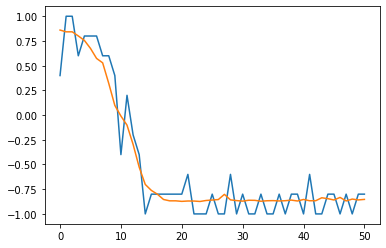

In [21]:
plt.plot(costs_gds[0])
plt.plot(c_exacts[0])

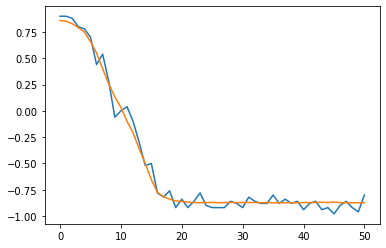

In [22]:
plt.plot(costs_gds[1])
plt.plot(c_exacts[1])

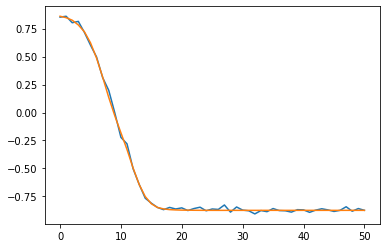

In [23]:
plt.plot(costs_gds[2])
plt.plot(c_exacts[2])

In [24]:
g = np.load("grid.npz")
xs = g["xs"]
ys = g["ys"]
zv = g["zv"]

In [25]:
times_0 = [10 * 4 * i for i in range(len(costs_gds[0]))]
times_1 = [100 * 4 * i for i in range(len(costs_gds[1]))]
times_2 = [1000 * 4 * i for i in range(len(costs_gds[2]))]

In [26]:
c = plt.rcParams['axes.prop_cycle'].by_key()['color']

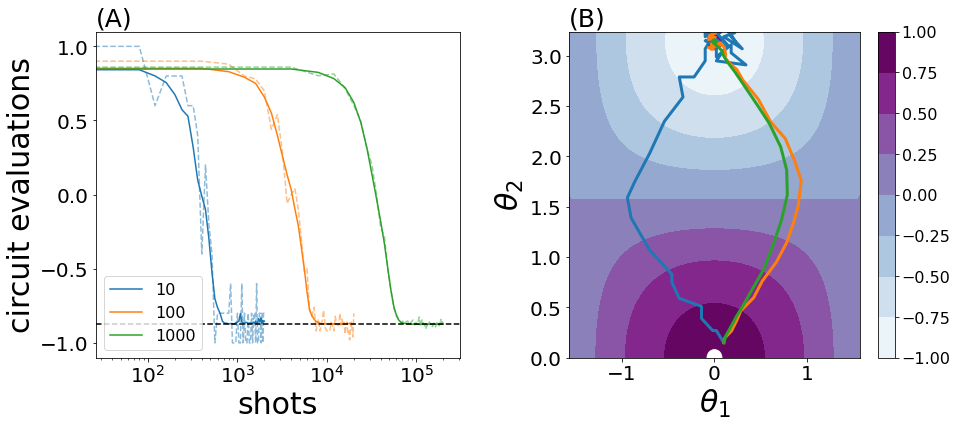

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].plot(times_0, costs_gds[0], "--", c=c[0], alpha=0.5)
axs[0].plot(times_0, c_exacts[0], c=c[0], label="10")
axs[0].plot(times_1, costs_gds[1], "--", c=c[1], alpha=0.5)
axs[0].plot(times_1, c_exacts[1], c=c[1], label="100")
axs[0].plot(times_2, costs_gds[2], "--", c=c[2], alpha=0.5)
axs[0].plot(times_2, c_exacts[2], c=c[2], label="1000")
axs[0].axhline(np.min(zv), linestyle="--", color="black")
axs[0].set_xlabel("shots", fontsize=30)
axs[0].set_ylabel("circuit evaluations", fontsize=30)
axs[0].tick_params(labelsize=20)
axs[0].set_xscale("log")
axs[0].legend(fontsize=16)

for i in range(3):
    axs[1].plot(weights_gds[i][:, 0], weights_gds[i][:, 1], c=c[i], linewidth=3)

axs[1].set_xlim(-(np.pi / 2), np.pi / 2)
axs[1].set_ylim(0, np.pi + 0.1)
    
cmap = plt.get_cmap('BuPu')
contour = axs[1].contourf(xs,ys,zv, cmap=cmap)
axs[1].set_xlabel(r"$\theta_{1}$", fontsize=30)
axs[1].set_ylabel(r"$\theta_{2}$", fontsize=30)
axs[1].tick_params(labelsize=20)
cbar = fig.colorbar(contour, ax=axs[1])
cbar.ax.tick_params(labelsize=16) 
circle1 = plt.Circle((0, 0), 0.08, color='white')
circle2 = plt.Circle((0, np.pi), 0.08, color='purple')
axs[1].add_artist(circle1)
axs[1].add_artist(circle2)

axs[0].set_title("(A)", fontsize=25, loc="left")
axs[1].set_title("(B)", fontsize=25, loc="left")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)
fig.savefig("gds.pdf", bbox_inches='tight')